# Baseline model for batch monitoring example

In [20]:
import requests
import datetime
import pandas as pd

from evidently import ColumnMapping
from evidently.report import Report
from evidently.metrics import ColumnDriftMetric, DatasetDriftMetric, DatasetMissingValuesMetric

from joblib import load, dump
from tqdm import tqdm

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [37]:
import os

files = [('green_tripdata_2024-03.parquet', './data')] # ('green_tripdata_2022-02.parquet', './data'), ('green_tripdata_2022-01.parquet', './data'),

print("Download files:")
for file, path in files:
    save_path = f"{path}/{file}"
    if os.path.exists(save_path):
        print(f"{file} already exists")
    else:
        url = f"https://d37ci6vzurychx.cloudfront.net/trip-data/{file}"
        resp = requests.get(url, stream=True)
        with open(save_path, "wb") as handle:
            for data in tqdm(resp.iter_content(),
                             desc=f"{file}",
                             postfix=f"save to {save_path}",
                             total=int(resp.headers["Content-Length"])):
                handle.write(data)

Download files:
green_tripdata_2024-03.parquet already exists


In [38]:
march_data = pd.read_parquet('data/green_tripdata_2024-03.parquet')

In [39]:
march_data.describe()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
count,57457.000000,57457,57457,55360.000000,57457.000000,57457.000000,55360.000000,57457.000000,57457.000000,57457.000000,57457.000000,57457.000000,57457.000000,0.0,57457.000000,57457.000000,55360.000000,55353.000000,55360.000000
mean,1.877334,2024-03-16 04:02:52.405399,2024-03-16 04:21:00.076039,1.179986,95.524688,138.629149,1.309538,13.522828,17.313474,0.904472,0.577410,2.386255,0.192537,NaN,0.979378,22.904832,1.321062,1.038047,0.737730
min,1.000000,2008-12-31 23:02:24,2008-12-31 23:02:30,1.000000,1.000000,1.000000,0.000000,0.000000,-295.080000,-2.500000,-0.500000,-1.560000,0.000000,NaN,-1.000000,-296.080000,1.000000,1.000000,-2.750000
25%,2.000000,2024-03-08 13:53:56,2024-03-08 14:13:49,1.000000,74.000000,74.000000,1.000000,1.100000,9.300000,0.000000,0.500000,0.000000,0.000000,NaN,1.000000,13.440000,1.000000,1.000000,0.000000
50%,2.000000,2024-03-15 22:49:01,2024-03-15 23:09:52,1.000000,75.000000,138.000000,1.000000,1.790000,13.500000,0.000000,0.500000,2.000000,0.000000,NaN,1.000000,18.500000,1.000000,1.000000,0.000000
75%,2.000000,2024-03-23 20:11:25,2024-03-23 20:34:48,1.000000,97.000000,220.000000,1.000000,3.100000,19.800000,1.000000,0.500000,3.610000,0.000000,NaN,1.000000,27.050000,2.000000,1.000000,2.750000
max,2.000000,2024-04-01 00:01:45,2024-04-01 16:11:00,99.000000,265.000000,265.000000,9.000000,125112.200000,841.600000,10.000000,4.250000,150.000000,26.760000,NaN,1.000000,856.980000,5.000000,2.000000,2.750000
std,0.328056,NaN,NaN,1.356719,57.285088,76.295346,0.967749,770.416255,14.958249,1.382446,0.366916,3.159273,1.184551,NaN,0.154253,17.013735,0.497858,0.191311,1.218039


In [40]:
march_data.shape

(57457, 20)

In [41]:
# create target
march_data["duration_min"] = march_data.lpep_dropoff_datetime - march_data.lpep_pickup_datetime
march_data.duration_min = march_data.duration_min.apply(lambda td : float(td.total_seconds())/60)

In [42]:
# filter out outliers
march_data = march_data[(march_data.duration_min >= 0) & (march_data.duration_min <= 60)]
march_data = march_data[(march_data.passenger_count > 0) & (march_data.passenger_count <= 8)]

<Axes: >

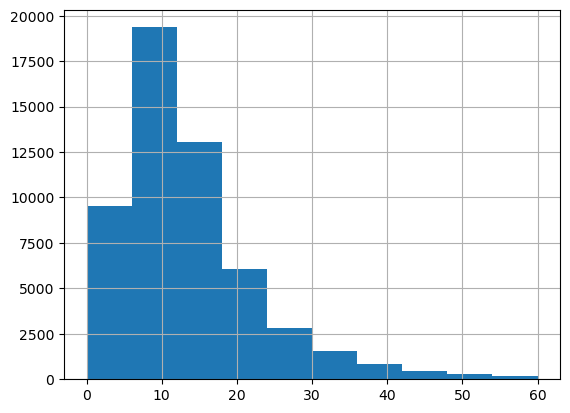

In [43]:
march_data.duration_min.hist()

In [44]:
# data labeling
target = "duration_min"
num_features = ["passenger_count", "trip_distance", "fare_amount", "total_amount"]
cat_features = ["PULocationID", "DOLocationID"]

In [45]:
march_data.shape

(54135, 21)

In [46]:
train_data = march_data[:30000]
val_data = march_data[30000:]

In [47]:
model = LinearRegression()

In [48]:
model.fit(train_data[num_features + cat_features], train_data[target])

LinearRegression()

In [49]:
train_preds = model.predict(train_data[num_features + cat_features])
train_data['prediction'] = train_preds

In [50]:
val_preds = model.predict(val_data[num_features + cat_features])
val_data['prediction'] = val_preds

In [51]:
print(mean_absolute_error(train_data.duration_min, train_data.prediction))
print(mean_absolute_error(val_data.duration_min, val_data.prediction))

3.7724732393594484
3.7168145679293687


# Dump model and reference data

In [52]:
with open('models/lin_reg.bin', 'wb') as f_out:
    dump(model, f_out)

FileNotFoundError: [Errno 2] No such file or directory: 'models/lin_reg.bin'

In [18]:
val_data.to_parquet('data/reference.parquet')

# Evidently Report

In [19]:
column_mapping = ColumnMapping(
    target=None,
    prediction='prediction',
    numerical_features=num_features,
    categorical_features=cat_features
)

In [20]:
report = Report(metrics=[
    ColumnDriftMetric(column_name='prediction'),
    DatasetDriftMetric(),
    DatasetMissingValuesMetric()
]
)

In [21]:
report.run(reference_data=train_data, current_data=val_data, column_mapping=column_mapping)

In [ ]:
report.show(mode='inline')

In [23]:
result = report.as_dict()

In [ ]:
result

In [ ]:
#prediction drift
result['metrics'][0]['result']['drift_score']

In [ ]:
#number of drifted columns
result['metrics'][1]['result']['number_of_drifted_columns']

In [ ]:
#share of missing values
result['metrics'][2]['result']['current']['share_of_missing_values']

# Evidently Dashboard

In [32]:
from evidently.metric_preset import DataDriftPreset, DataQualityPreset

from evidently.ui.workspace import Workspace
from evidently.ui.dashboards import DashboardPanelCounter, DashboardPanelPlot, CounterAgg, PanelValue, PlotType, ReportFilter
from evidently.renderers.html_widgets import WidgetSize

In [30]:
ws = Workspace("workspace")

In [ ]:
project = ws.create_project("NYC Taxi Data Quality Project")
project.description = "My project descriotion"
project.save()

In [ ]:
# Define the quantile and drift metrics
quantile_metric = ColumnQuantileMetric(column_name="fare_amount", quantile=0.5)
drift_metric = ColumnDriftMetric(column_name="fare_amount")

regular_report = Report(
    metrics=[
        DataQualityPreset()
    ],
    timestamp=datetime.datetime(2022,1,28)
)

regular_report.run(reference_data=None,
                  current_data=val_data.loc[val_data.lpep_pickup_datetime.between('2022-01-28', '2022-01-29', inclusive="left")],
                  column_mapping=column_mapping)

regular_report

In [34]:
ws.add_report(project.id, regular_report)

In [ ]:
#configure the dashboard
project.dashboard.add_panel(
    DashboardPanelCounter(
        filter=ReportFilter(metadata_values={}, tag_values=[]),
        agg=CounterAgg.NONE,
        title="NYC taxi data dashboard"
    )
)

project.dashboard.add_panel(
    DashboardPanelPlot(
        filter=ReportFilter(metadata_values={}, tag_values=[]),
        title="Inference Count",
        values=[
            PanelValue(
                metric_id="DatasetSummaryMetric",
                field_path="current.number_of_rows",
                legend="count"
            ),
        ],
        plot_type=PlotType.BAR,
        size=WidgetSize.HALF,
    ),
)

project.dashboard.add_panel(
    DashboardPanelPlot(
        filter=ReportFilter(metadata_values={}, tag_values=[]),
        title="Number of Missing Values",
        values=[
            PanelValue(
                metric_id="DatasetSummaryMetric",
                field_path="current.number_of_missing_values",
                legend="count"
            ),
        ],
        plot_type=PlotType.LINE,
        size=WidgetSize.HALF,
    ),
)

project.save()

In [ ]:
regular_report = Report(
    metrics=[
        DataQualityPreset()
    ],
    timestamp=datetime.datetime(2022,1,29)
)

regular_report.run(reference_data=None,
                  current_data=val_data.loc[val_data.lpep_pickup_datetime.between('2022-01-29', '2022-01-30', inclusive="left")],
                  column_mapping=column_mapping)

regular_report

In [37]:
ws.add_report(project.id, regular_report)